In [1]:
from generator import Generator
from critic import Critic
from dog_dataset import DogData

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch import optim

In [3]:
batchSize = 20

In [4]:
transform = transforms.Compose( [ transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) ] )
dogdata = DogData(transform)
dogloader = DataLoader(dogdata, shuffle=True, batch_size=batchSize, num_workers=3)

In [5]:
def get_critic_scores(real_batch, batchSize, critic, generator):
    generator.batchSize = batchSize
    critic.batchSize = batchSize
    #generate fake images
    randoBatch = torch.randn([batchSize, 100, 1, 1])
    generated = generator(randoBatch)
    #compute scores of both real and fake using the critic
    real_scores = critic(real_batch[0])
    gen_scores = critic(generated)
    return ( torch.sum(real_scores) , torch.sum(gen_scores) )

In [6]:
def get_generator_score(batchSize, critic, generator):
    generator.batchSize = batchSize
    #generate fake images
    randoBatch = torch.randn([batchSize, 100, 1, 1])
    generated = generator(randoBatch)
    #compute scores of generated using critic
    gen_scores = critic(generated)
    return torch.sum(gen_scores)

In [7]:
class WeightClipper(object):

    def __init__(self, frequency=5):
        self.frequency = frequency

    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = w.clamp(-0.01,0.01)
            module.weight.data = w

In [8]:
critic = Critic()
generator = Generator()
clipper = WeightClipper()
critic.apply(clipper)

Critic(
  (convBlocks): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fcBlocks): Sequential(
    (0): Sequential(
      (0): Linear(in_features=67712, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Se

In [9]:
num_epochs = 300
critic_epochs = 1
gen_epochs = 1

In [10]:
criticOptim = optim.RMSprop(critic.parameters(), lr=0.005, momentum=0)
genOptim = optim.Adam(generator.parameters(), lr=0.05)#, momentum=0.5)

In [11]:
import matplotlib.pyplot as plt

Entering epoch yay: 0
Critic batch: 0
-1.2975437641143799
-1.297724962234497
-0.0001811981201171875
Generator batch: 0
3.433364152908325
Entering epoch yay: 1
Critic batch: 0
-3.1790969371795654
-3.4144985675811768
-0.23540163040161133
Generator batch: 0
5.4969305992126465
Entering epoch yay: 2
Critic batch: 0
-1.678228497505188
-5.3486175537109375
-3.670389175415039
Generator batch: 0
8.889432907104492
Entering epoch yay: 3
Critic batch: 0
-2.9488182067871094
-9.501235961914062
-6.552417755126953
Generator batch: 0
15.648354530334473
Entering epoch yay: 4
Critic batch: 0
-1.7242306470870972
-14.989906311035156
-13.26567554473877
Generator batch: 0
23.549943923950195
Entering epoch yay: 5
Critic batch: 0
-5.93524694442749
-24.857717514038086
-18.922470092773438
Generator batch: 0
29.17894744873047
Entering epoch yay: 6
Critic batch: 0
-1.9878171682357788
-29.973064422607422
-27.985246658325195
Generator batch: 0
39.53411865234375
Entering epoch yay: 7
Critic batch: 0
-5.628995418548584

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


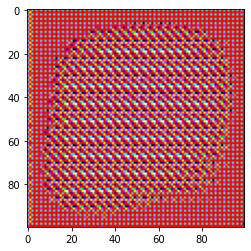

Entering epoch yay: 20
Critic batch: 0
-3.2943778038024902
-150.88970947265625
-147.5953369140625
Generator batch: 0
147.87208557128906
Entering epoch yay: 21
Critic batch: 0
-4.077719211578369
-154.29124450683594
-150.21353149414062
Generator batch: 0
173.5078887939453
Entering epoch yay: 22
Critic batch: 0
-2.9304823875427246
-145.7885284423828
-142.85804748535156
Generator batch: 0
166.30963134765625
Entering epoch yay: 23
Critic batch: 0
-4.373952388763428
-132.6695556640625
-128.2956085205078
Generator batch: 0
194.36546325683594
Entering epoch yay: 24
Critic batch: 0
-3.799980640411377
-179.8945770263672
-176.09458923339844
Generator batch: 0
197.68113708496094
Entering epoch yay: 25
Critic batch: 0
-4.04044246673584
-195.7001495361328
-191.6597137451172
Generator batch: 0
208.46424865722656
Entering epoch yay: 26
Critic batch: 0
-3.4931576251983643
-193.68917846679688
-190.19601440429688
Generator batch: 0
200.6329803466797
Entering epoch yay: 27
Critic batch: 0
-4.9239950180053

In [ ]:
for epoch in range(num_epochs):
    print('Entering epoch yay: ' + str(epoch))
    realScore = 0.0 
    fakeScore = 0.0
    mainLoss = 0.0
    #critic training loop
    for batch_no, batch in enumerate(dogloader):
        if (critic_epochs == 0):
            break
        print('Critic batch: ' + str(batch_no))
        scores = get_critic_scores(batch, batchSize, critic, generator)
        real_score = scores[0]
        gen_score = scores[1]
        #loss function
        loss = -( real_score - gen_score ) #+ 0.01 * ( torch.pow(real_score,2) + torch.pow(gen_score,2) ) #penalize for distance away from 0
        #some tracking of numbers here
        realScore += real_score.item()
        fakeScore += gen_score.item()
        mainLoss += loss.item()
        #optimize
        criticOptim.zero_grad()
        loss.backward()
        criticOptim.step()
        
        if (batch_no % critic_epochs == critic_epochs-1):
            break
    print(realScore)
    print(fakeScore)
    print(mainLoss)
    
    mainLoss = 0.0
    #generator training loop
    for gepoch in range(gen_epochs):
        print('Generator batch: ' + str(gepoch))
        gen_score = get_generator_score(batchSize, critic, generator)
        #loss function
        loss = -gen_score
        #tracking of numbers
        mainLoss += loss.item()
        #optimize
        genOptim.zero_grad()
        loss.backward()
        genOptim.step()
    print(mainLoss)
    
    if (epoch % 20 == 19): #give us something to look at every so often
        generator.eval()
        rando = torch.randn([1, 100, 1, 1])
        gen = generator(rando)
        plt.imshow(gen[0].permute(1,2,0).detach().numpy())
        plt.show()
        generator.train()

In [ ]:
critic.batchSize = 1
critic.eval()
print(critic(dogdata[800][0].unsqueeze(0)))
rando = torch.randn([1, 100, 1, 1])
print(critic(generator(rando)))

gen = generator(rando)
plt.imshow(gen[0].permute(1,2,0).detach().numpy())
plt.show()

plt.imshow(dogdata[0][0].permute(1,2,0))
plt.show()